#                                Project Aimoscore



## Description of movement assessment dataset


• Deep squat data assessed for ca 2100 people

• 1 expert score (AIMO Score, large score is good)

• 38 movement features (large is bad)

• 2 time features (large is bad)

• 1 estimated score (indirect feature, large score is good)

### Import Libraries

In [1]:
import pandas as pd
import seaborn as sns
import seaborn as sn
import matplotlib as matplot
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import sklearn
import scipy
import time  


from sklearn.pipeline import Pipeline
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
from sklearn.decomposition import KernelPCA

### Configuration

In [2]:
random_state = 42
train_size = 0.8

# maximum polynomial degree for crossvalidationplotpolynomial_regression function
maxdegree=4

#K-Fold
cv = 5
minDepths=1
maxDepths=40



### Use full function

In [3]:
def high_corrolation(corrMatrix):
    columns= np.full((corrMatrix.shape[0],),True, dtype= bool)
    for i in range(corrMatrix.shape[0]):
        for j in range(i+1, corrMatrix.shape[0]):
            if corrMatrix.iloc[i,j]>=0.8:
                if columns[j]:
                    columns[j] = False
    return columns

In [4]:
def p_value_select(X, y):
    cols = list(X.columns)
    pmax=1
    while(len(cols)>0):
        p=[]
        X1=X[cols]
        X1= sm.add_constant(X1)
        model = sm.OLS(y,X1).fit()
        p = pd.Series(model.pvalues.values[1:],index = cols)
        pmax = max(p)
        feature_with_p_max = p.idxmax()
        if(pmax>0.05):
            cols.remove(feature_with_p_max)
        else:
            break
            
    return cols

In [5]:

   def get_percentage(new_value,orginal_value):
        return((new_value-orginal_value)/orginal_value)*100
        

In [6]:
def crossvalidation_polynomial_regression_model(X,y,cv=5,scoring='r2',mindegree=1,maxdegree=maxdegree):
    training_error=[]
    cross_validation_error=[]
    
    for d in range(1,maxdegree):
        x_poly=PolynomialFeatures(degree=d).fit_transform(X)
        poly=LinearRegression()
        model=poly.fit(x_poly,y)
        y_pred=model.predict(x_poly)
        mse=mean_squared_error(y,y_pred)
        
        cvs=cross_val_score(poly,x_poly,y,cv=5,scoring='r2')
        training_error.append(mse)
        cross_validation_error.append(np.mean(cvs))
    
    return cross_validation_error, training_error

def crossvalidationplotpolynomial_regression(cv_cross_validation_error,cv_training_error,mindegree=1,maxdegree=maxdegree):
    degrees = range (1,maxdegree)
    fig,ax=plt.subplots(figsize=(15,5))
    ax.plot(degrees,cv_cross_validation_error,'-o',label='cv_cross_validation_error')
    ax.plot(degrees,cv_training_error,'-*',label='cv_training_error')
    ax.set_xlabel('Degree',fontsize=20)
    ax.set_ylabel('r-squared',fontsize=20)
    ax.set_title('r-squared VS Degree',fontsize=25)
    ax.set_xticks(degrees)
    ax.legend()
       

In [7]:
from sklearn.model_selection import cross_val_score,KFold
from sklearn.tree import DecisionTreeRegressor

def crossValidationOnTreeRegressor(X, y,minDepths, maxDepths, cv=5, scoring='r2',random_state= random_state):
    kfolds = KFold(n_splits = cv, shuffle = True, random_state = random_state)
    scores = []
    stds = []
    means = []
    accuracies = []
    
    for depth in range(minDepths,maxDepths+1):
        tree = DecisionTreeRegressor(max_depth=depth,random_state=random_state)
        cvs = cross_val_score(tree, X, y, cv=kfolds, scoring=scoring)
        scores.append(cvs)
        means.append(cvs.mean())
        stds.append(cvs.std())
        accuracies.append(tree.fit(X, y).score(X, y))
        
    means = np.array(means)
    stds = np.array(stds)
    accuracies = np.array(accuracies)
    return means, stds, accuracies

def crossValidationPlotOnTree(minDepths,maxDepths, cv_means, cv_stds, cv_accuracies, title):
    depths = range(minDepths,maxDepths+1)
    fig, ax = plt.subplots(1,1, figsize=(15,5))
    ax.plot(depths, cv_means, '-o', label='mean cross-validation accuracy', alpha=0.9)
    ax.fill_between(depths, cv_means-2*cv_stds, cv_means+2*cv_stds, alpha=0.2)
    ylim = plt.ylim()
    ax.plot(depths, cv_accuracies, '-*', label='train accuracy', alpha=0.9)
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Tree depth', fontsize=14)
    ax.set_ylabel('R2', fontsize=14)
    ax.set_ylim(ylim)
    ax.set_xticks(depths)
    ax.legend()

In [8]:
from sklearn.base import BaseEstimator,TransformerMixin

class OutlierRemover(BaseEstimator,TransformerMixin):
    def __init__(self,factor=1.5):
        self.factor = factor
        
    def outlier_detector(self,X,y=None):
        X = pd.Series(X).copy()
        q1 = X.quantile(0.25)
        q3 = X.quantile(0.75)
        iqr = q3 - q1
        self.lower_bound.append(q1 - (self.factor * iqr))
        self.upper_bound.append(q3 + (self.factor * iqr))

    def fit(self,X,y=None):
        self.lower_bound = []
        self.upper_bound = []
        X.apply(self.outlier_detector)
        return self
    
    def transform(self,X,y=None):
        X = pd.DataFrame(X).copy()
        for i in range(X.shape[1]):
            x = X.iloc[:, i].copy()
            x[(x < self.lower_bound[i]) | (x > self.upper_bound[i])] = np.nan
            X.iloc[:, i] = x
        return X
    
outlier_remover = OutlierRemover()

### Read tha data

In [9]:
AimoscoreData = pd.read_csv("AimoScore_WeakLink_big_scores.csv")
AimoscoreData.drop('EstimatedScore',inplace=True, axis=1)
AimoscoreData.head()

,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_18_NASM_Deviation,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation
0,0.323667,0.538020,0.815878,0.346724,0.382114,0.302248,0.947872,0.275945,0.521760,0.457198,...,0.587757,0.833094,0.656624,0.642276,0.552846,0.648972,0.578192,0.560019,0.821616,0.818747
1,0.323699,0.443807,0.306552,0.823529,0.188905,0.497370,0.140124,0.664275,0.521760,0.729316,...,0.441416,0.670971,0.721186,0.826399,0.805356,0.848876,0.889048,0.816834,0.307987,0.248207
2,0.848327,0.603539,0.373984,0.346724,0.590626,0.341942,0.298900,0.276901,0.623625,0.658058,...,0.733142,0.670971,0.656624,0.642276,0.690579,0.648972,0.578192,0.555715,0.218556,0.235294
3,0.351332,0.484935,0.623625,0.380201,0.975132,0.509326,0.888570,0.363462,0.847441,0.237207,...,0.934003,0.953611,0.656624,0.642276,0.552846,0.648972,0.578192,0.744620,0.458154,0.432807
4,0.627181,0.860832,0.657580,0.745576,0.552846,0.375897,0.483022,0.388331,0.521760,0.387853,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.308943,0.805356,0.774271


### 1.Check Data

#### 1.1 Lets have a look at the data and see identify Object/Categorical values and Continuous values

In [10]:
AimoscoreData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2094 entries, 0 to 2093
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AimoScore              2094 non-null   float64
 1   No_1_Angle_Deviation   2094 non-null   float64
 2   No_2_Angle_Deviation   2094 non-null   float64
 3   No_3_Angle_Deviation   2094 non-null   float64
 4   No_4_Angle_Deviation   2094 non-null   float64
 5   No_5_Angle_Deviation   2094 non-null   float64
 6   No_6_Angle_Deviation   2094 non-null   float64
 7   No_7_Angle_Deviation   2094 non-null   float64
 8   No_8_Angle_Deviation   2094 non-null   float64
 9   No_9_Angle_Deviation   2094 non-null   float64
 10  No_10_Angle_Deviation  2094 non-null   float64
 11  No_11_Angle_Deviation  2094 non-null   float64
 12  No_12_Angle_Deviation  2094 non-null   float64
 13  No_13_Angle_Deviation  2094 non-null   float64
 14  No_1_NASM_Deviation    2094 non-null   float64
 15  No_2

#### 1.2 Let's have a look how many values are missing¶

In [11]:
AimoscoreData.isnull().sum()

AimoScore                0
No_1_Angle_Deviation     0
No_2_Angle_Deviation     0
No_3_Angle_Deviation     0
No_4_Angle_Deviation     0
No_5_Angle_Deviation     0
No_6_Angle_Deviation     0
No_7_Angle_Deviation     0
No_8_Angle_Deviation     0
No_9_Angle_Deviation     0
No_10_Angle_Deviation    0
No_11_Angle_Deviation    0
No_12_Angle_Deviation    0
No_13_Angle_Deviation    0
No_1_NASM_Deviation      0
No_2_NASM_Deviation      0
No_3_NASM_Deviation      0
No_4_NASM_Deviation      0
No_5_NASM_Deviation      0
No_6_NASM_Deviation      0
No_7_NASM_Deviation      0
No_8_NASM_Deviation      0
No_9_NASM_Deviation      0
No_10_NASM_Deviation     0
No_11_NASM_Deviation     0
No_12_NASM_Deviation     0
No_13_NASM_Deviation     0
No_14_NASM_Deviation     0
No_15_NASM_Deviation     0
No_16_NASM_Deviation     0
No_17_NASM_Deviation     0
No_18_NASM_Deviation     0
No_19_NASM_Deviation     0
No_20_NASM_Deviation     0
No_21_NASM_Deviation     0
No_22_NASM_Deviation     0
No_23_NASM_Deviation     0
N

#### 1.3 Shows records which are duplicated

In [12]:
AimoscoreData[AimoscoreData.duplicated() ]

,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_18_NASM_Deviation,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation
316,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
623,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
800,0.407197,0.27977,0.150167,0.346724,0.329029,0.952176,0.658537,0.928742,0.52176,0.556193,...,0.441416,0.670971,0.656624,0.889527,0.952176,0.811095,0.578192,0.872310,0.68484,0.711621
813,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
825,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
881,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
887,0.407197,0.27977,0.150167,0.346724,0.329029,0.952176,0.658537,0.928742,0.52176,0.556193,...,0.441416,0.670971,0.656624,0.889527,0.952176,0.811095,0.578192,0.872310,0.68484,0.711621
1037,0.407197,0.27977,0.131038,0.346724,0.317073,0.945481,0.646581,0.913439,0.52176,0.570540,...,0.789574,0.670971,0.945002,0.642276,0.596365,0.648972,0.749880,0.943568,0.68484,0.711621
1158,0.406613,0.27977,0.153037,0.346724,0.322334,0.923482,0.650885,0.906743,0.52176,0.546150,...,0.441416,0.670971,0.656624,0.900048,0.958393,0.825921,0.578192,0.868962,0.68484,0.711621
1373,0.407106,0.27977,0.153037,0.346724,0.322334,0.923482,0.650885,0.906743,0.52176,0.546150,...,0.441416,0.670971,0.656624,0.900048,0.958393,0.825921,0.578192,0.868962,0.68484,0.711621


#### interpretation:

 We  don't have missing values .we have identical data .

#### 1.5 check data distribution

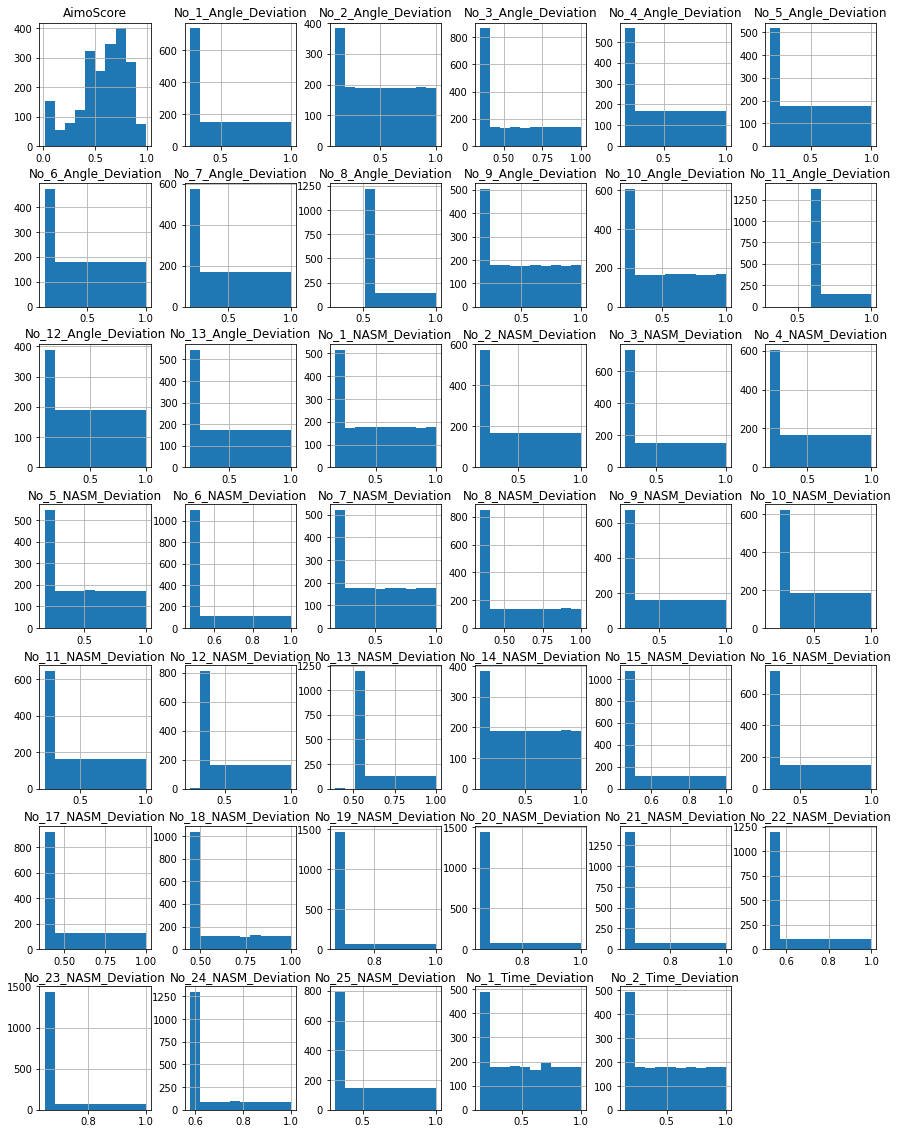

In [13]:
AimoscoreData.hist(figsize=(15,20))
plt.show()

In [14]:
AimoscoreData.describe()

,AimoScore,No_1_Angle_Deviation,No_2_Angle_Deviation,No_3_Angle_Deviation,No_4_Angle_Deviation,No_5_Angle_Deviation,No_6_Angle_Deviation,No_7_Angle_Deviation,No_8_Angle_Deviation,No_9_Angle_Deviation,...,No_18_NASM_Deviation,No_19_NASM_Deviation,No_20_NASM_Deviation,No_21_NASM_Deviation,No_22_NASM_Deviation,No_23_NASM_Deviation,No_24_NASM_Deviation,No_25_NASM_Deviation,No_1_Time_Deviation,No_2_Time_Deviation
count,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,...,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000,2094.000000
mean,0.572740,0.539248,0.504462,0.560258,0.518065,0.513932,0.510336,0.519434,0.635923,0.512548,...,0.598075,0.725505,0.715943,0.706319,0.652969,0.710774,0.667517,0.548089,0.512021,0.512373
std,0.236510,0.239284,0.282136,0.217828,0.264104,0.270076,0.274473,0.262884,0.153280,0.271193,...,0.184207,0.095008,0.100437,0.105886,0.141000,0.103196,0.130989,0.230642,0.273056,0.272647
min,0.010000,0.279770,0.092300,0.346724,0.188905,0.163080,0.140124,0.194165,0.303247,0.156385,...,0.441416,0.670971,0.656624,0.640401,0.525310,0.648972,0.578192,0.308943,0.148733,0.151124
25%,0.407907,0.279770,0.250149,0.346724,0.250239,0.250717,0.250717,0.250717,0.521760,0.250717,...,0.441416,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.308943,0.250717,0.250717
50%,0.617248,0.500000,0.500000,0.500000,0.500000,0.500478,0.500478,0.500956,0.521760,0.500478,...,0.500956,0.670971,0.656624,0.642276,0.552846,0.648972,0.578192,0.500000,0.500478,0.500478
75%,0.759378,0.749761,0.750239,0.750239,0.750239,0.750239,0.750239,0.750239,0.749761,0.750239,...,0.751196,0.751196,0.751196,0.749761,0.749880,0.751196,0.751196,0.750239,0.750239,0.750239
max,0.993987,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [15]:
AimoscoreData.skew()


AimoScore               -0.664833
No_1_Angle_Deviation     0.384841
No_2_Angle_Deviation     0.065707
No_3_Angle_Deviation     0.530476
No_4_Angle_Deviation     0.210555
No_5_Angle_Deviation     0.166880
No_6_Angle_Deviation     0.128641
No_7_Angle_Deviation     0.217061
No_8_Angle_Deviation     0.985863
No_9_Angle_Deviation     0.154091
No_10_Angle_Deviation    0.246783
No_11_Angle_Deviation    1.373852
No_12_Angle_Deviation    0.067657
No_13_Angle_Deviation    0.191136
No_1_NASM_Deviation      0.166880
No_2_NASM_Deviation      0.217061
No_3_NASM_Deviation      0.384841
No_4_NASM_Deviation      0.246783
No_5_NASM_Deviation      0.191136
No_6_NASM_Deviation      0.846652
No_7_NASM_Deviation      0.169916
No_8_NASM_Deviation      0.508921
No_9_NASM_Deviation      0.311871
No_10_NASM_Deviation     0.396462
No_11_NASM_Deviation     0.440674
No_12_NASM_Deviation     0.473021
No_13_NASM_Deviation     1.063228
No_14_NASM_Deviation     0.065696
No_15_NASM_Deviation     0.812818
No_16_NASM_Dev

In [16]:
AimoscoreData.kurtosis() 

AimoScore               -0.275793
No_1_Angle_Deviation    -1.272582
No_2_Angle_Deviation    -1.261023
No_3_Angle_Deviation    -1.174676
No_4_Angle_Deviation    -1.311923
No_5_Angle_Deviation    -1.302087
No_6_Angle_Deviation    -1.294255
No_7_Angle_Deviation    -1.313095
No_8_Angle_Deviation    -0.485477
No_9_Angle_Deviation    -1.303298
No_10_Angle_Deviation   -1.311406
No_11_Angle_Deviation    0.563736
No_12_Angle_Deviation   -1.262513
No_13_Angle_Deviation   -1.309155
No_1_NASM_Deviation     -1.302087
No_2_NASM_Deviation     -1.313095
No_3_NASM_Deviation     -1.272582
No_4_NASM_Deviation     -1.311406
No_5_NASM_Deviation     -1.309155
No_6_NASM_Deviation     -0.767960
No_7_NASM_Deviation     -1.304417
No_8_NASM_Deviation     -1.196042
No_9_NASM_Deviation     -1.304760
No_10_NASM_Deviation    -1.265252
No_11_NASM_Deviation    -1.243327
No_12_NASM_Deviation    -1.221116
No_13_NASM_Deviation    -0.337485
No_14_NASM_Deviation    -1.261809
No_15_NASM_Deviation    -0.823509
No_16_NASM_Dev

In [17]:
s=AimoscoreData.skew() 
highly_positively_skewwd=s.where(s>1)
highly_positively_skewwd

AimoScore                     NaN
No_1_Angle_Deviation          NaN
No_2_Angle_Deviation          NaN
No_3_Angle_Deviation          NaN
No_4_Angle_Deviation          NaN
No_5_Angle_Deviation          NaN
No_6_Angle_Deviation          NaN
No_7_Angle_Deviation          NaN
No_8_Angle_Deviation          NaN
No_9_Angle_Deviation          NaN
No_10_Angle_Deviation         NaN
No_11_Angle_Deviation    1.373852
No_12_Angle_Deviation         NaN
No_13_Angle_Deviation         NaN
No_1_NASM_Deviation           NaN
No_2_NASM_Deviation           NaN
No_3_NASM_Deviation           NaN
No_4_NASM_Deviation           NaN
No_5_NASM_Deviation           NaN
No_6_NASM_Deviation           NaN
No_7_NASM_Deviation           NaN
No_8_NASM_Deviation           NaN
No_9_NASM_Deviation           NaN
No_10_NASM_Deviation          NaN
No_11_NASM_Deviation          NaN
No_12_NASM_Deviation          NaN
No_13_NASM_Deviation     1.063228
No_14_NASM_Deviation          NaN
No_15_NASM_Deviation          NaN
No_16_NASM_Dev

#### interpretation:

According to skewd values and mean values in 8 columns we have highly positively skewwd(>1) and in 6 columns we have moderately positively skewed(0.5<> 1)and in one colimns we have moderately Negatively skewed(-1 <> -0.5)


kurtosis values show all values are <3 that means distribution is shorter, tails are thinner than the normal distribution. The peak is lower and broader than Mesokurtic.That data are light-tailed or lack of outliers. 

we have negative kurtosis, it is said to be platykurtic, which means that it has a flatter peak and thinner tails compared to a normal distribution. This simply means that more data values are located near the mean and less data values are located on the tails.


### 2.Feature celection

#### 2.1 check features with high corrolation 


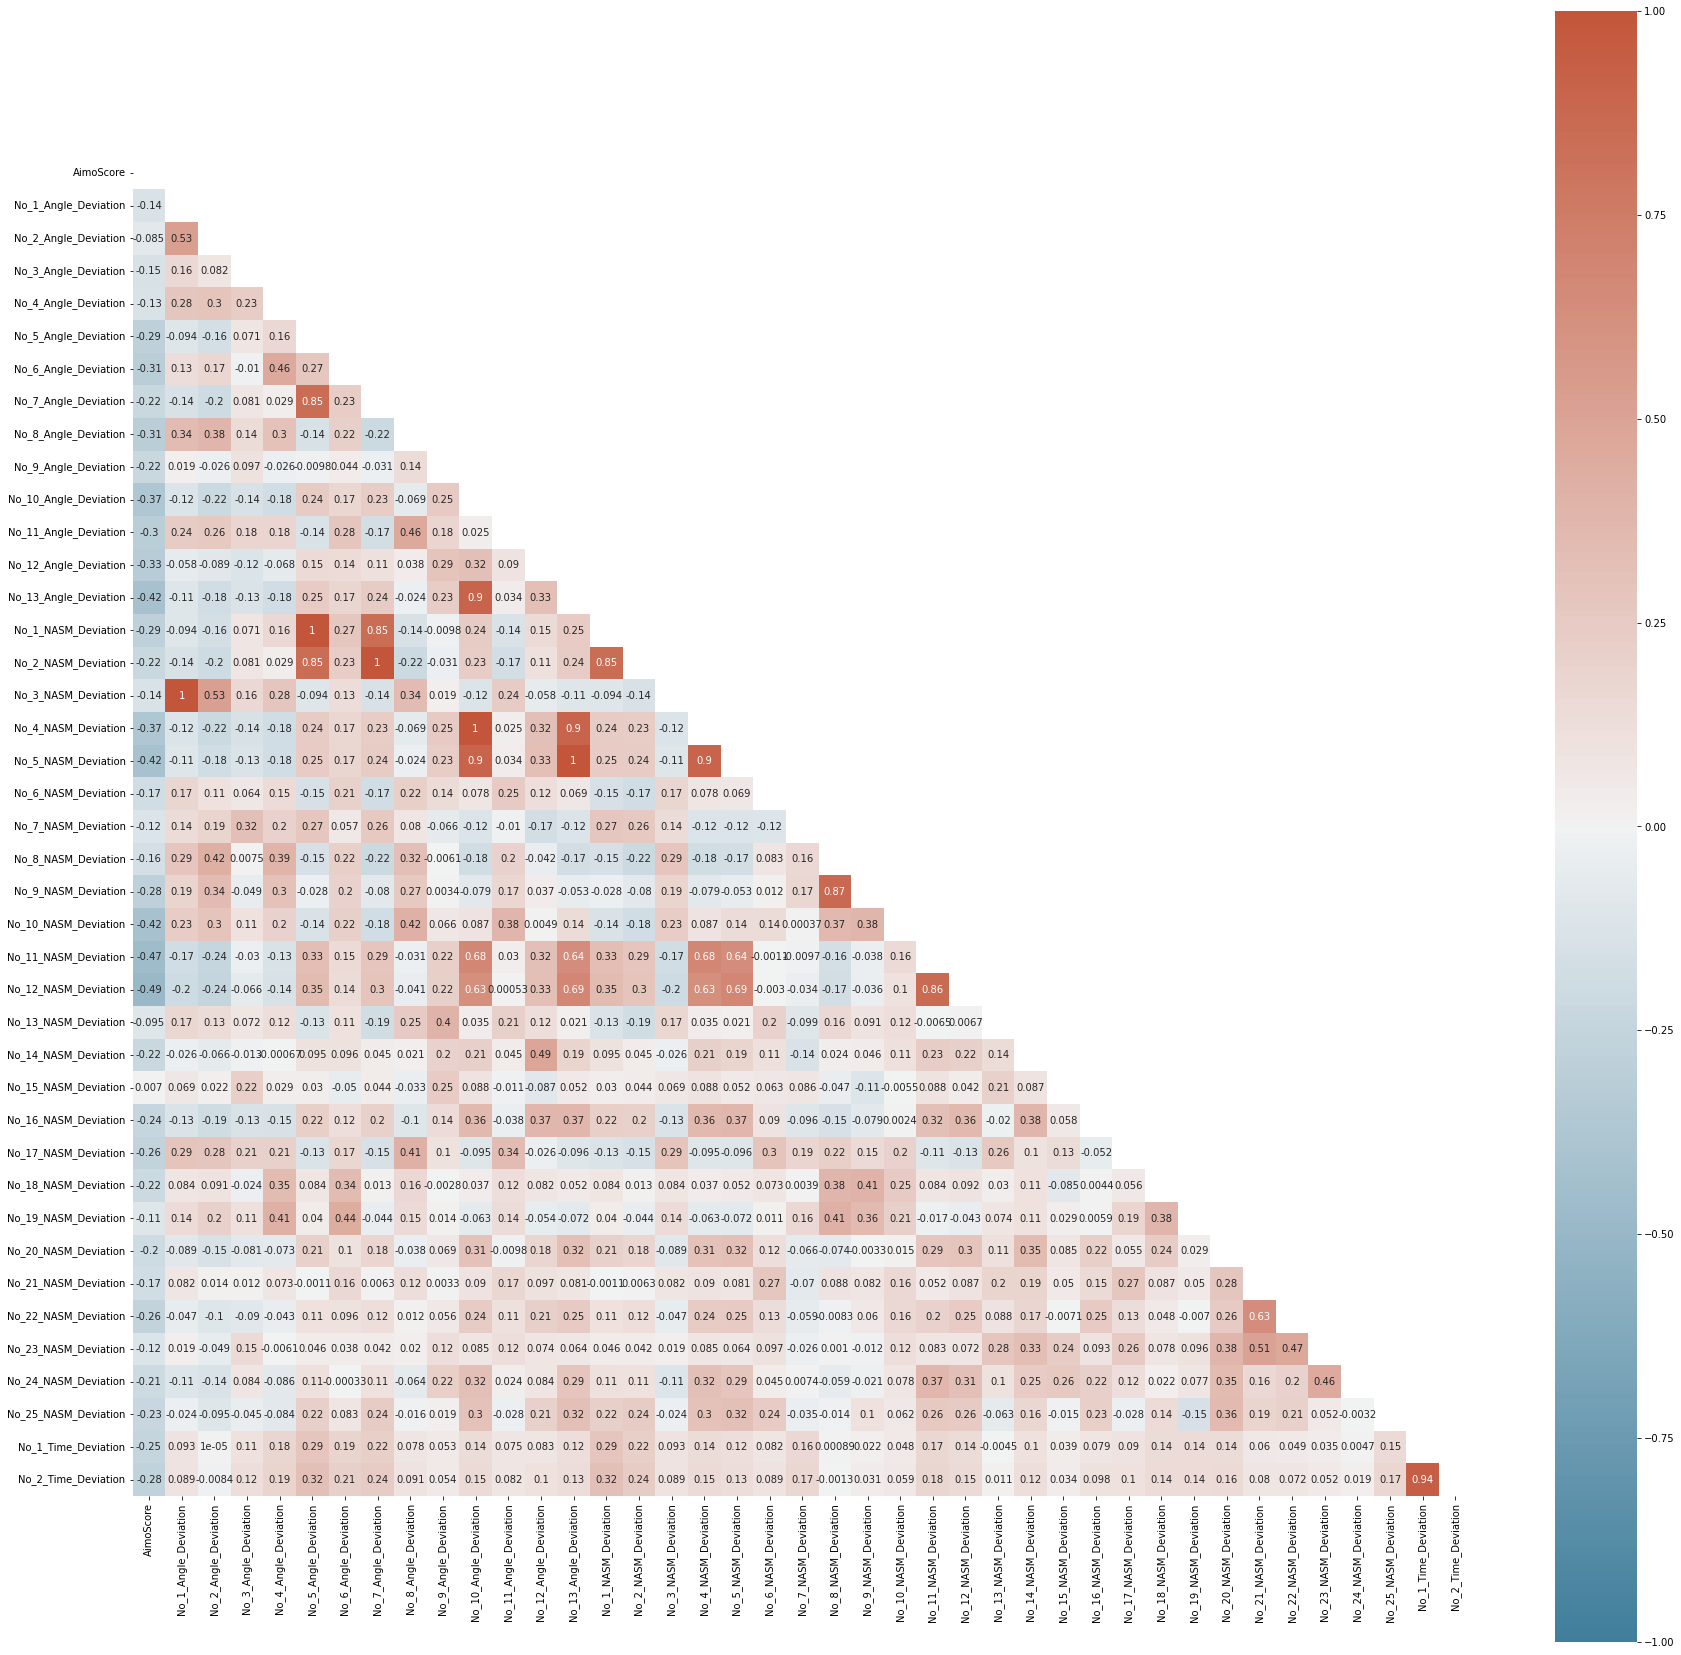

In [18]:
corrMatrix= AimoscoreData.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

fig, ax = plt.subplots(figsize=(30,30)) 

cmap = sn.diverging_palette(230, 20, as_cmap=True)

sn.heatmap(corrMatrix, mask= mask, cmap=cmap,  vmin=-1, vmax=1, center=0,square =True, annot= True, ax=ax)
plt.show()

In [19]:
## sn.pairplot(AimoscoreData)
## plt.show()

Use the function high_corrolation() to determine which features have high correlation together and remove one of two features that have a correlathion higher then Specific value. in this case we consider corrolation higher than 0.8.

In [20]:
columns = high_corrolation(AimoscoreData.corr())
selected_columns = AimoscoreData.columns[columns]
print(selected_columns)
print("Number of Features after remove one of two features that have a correlathion higher then 0.8:", len(selected_columns))
columns_without_highcorrolation =selected_columns

Index(['AimoScore', 'No_1_Angle_Deviation', 'No_2_Angle_Deviation',
       'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation',
       'No_6_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation',
       'No_10_Angle_Deviation', 'No_11_Angle_Deviation',
       'No_12_Angle_Deviation', 'No_6_NASM_Deviation', 'No_7_NASM_Deviation',
       'No_8_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation',
       'No_13_NASM_Deviation', 'No_14_NASM_Deviation', 'No_15_NASM_Deviation',
       'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation',
       'No_19_NASM_Deviation', 'No_20_NASM_Deviation', 'No_21_NASM_Deviation',
       'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation',
       'No_25_NASM_Deviation', 'No_1_Time_Deviation'],
      dtype='object')
Number of Features after remove one of two features that have a correlathion higher then 0.8: 31


#### interpretation:

There are some feature that have high corrolation.A group of highly correlated features will increase the complexity of the algorithm, thus increasing the risk of errors.


#### 2.2 check p_values

In [21]:
X= AimoscoreData[selected_columns].drop(["AimoScore"], axis=1)
y = AimoscoreData["AimoScore"]
X1= sm.add_constant(X)
model=sm.OLS(y,X1)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:              AimoScore   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.544
Method:                 Least Squares   F-statistic:                     84.17
Date:                Wed, 09 Mar 2022   Prob (F-statistic):               0.00
Time:                        10:02:19   Log-Likelihood:                 885.15
No. Observations:                2094   AIC:                            -1708.
Df Residuals:                    2063   BIC:                            -1533.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.42

In [22]:
print(p_value_select(X,y))
print("numbers of significant features for P > 0.05 :" ,len(p_value_select(X,y)))
columns_p = p_value_select(X,y)

['No_1_Angle_Deviation', 'No_3_Angle_Deviation', 'No_4_Angle_Deviation', 'No_5_Angle_Deviation', 'No_6_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation', 'No_10_Angle_Deviation', 'No_11_Angle_Deviation', 'No_12_Angle_Deviation', 'No_8_NASM_Deviation', 'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_15_NASM_Deviation', 'No_16_NASM_Deviation', 'No_17_NASM_Deviation', 'No_18_NASM_Deviation', 'No_19_NASM_Deviation', 'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_24_NASM_Deviation', 'No_1_Time_Deviation']
numbers of significant features for P > 0.05 : 22


#### interpretation:

According to p_value 22 features are significant

#### 2.3 Dimentionaly reduction with PCA method

##### 2.3.1 first we remove outlier whith use of  InterQuartlie Range (IQR) method

In [23]:
from scipy import stats
AimoscoreData_01=AimoscoreData
Q1 = AimoscoreData_01.quantile(0.25)
Q3 = AimoscoreData_01.quantile(0.75)
IQR = Q3 - Q1
AimoscoreData_01_out = AimoscoreData_01[~((AimoscoreData_01 < (Q1 - 1.5 * IQR)) |( AimoscoreData_01> (Q3 + 1.5 * IQR))).any(axis=1)]
AimoscoreData_01_out.shape

(1362, 41)

In [24]:
from sklearn.model_selection import train_test_split
X= AimoscoreData_01_out.drop(["AimoScore"], axis=1)
y = AimoscoreData_01_out["AimoScore"]
train_X_01, test_X_01, train_y_01, test_y_01= train_test_split(X, y, train_size= train_size ,random_state=random_state )

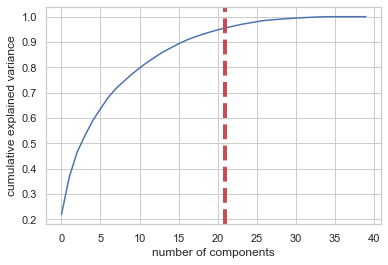

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.219010,0.219010
1,0.365872,0.146863
2,0.464480,0.098607
3,0.529603,0.065123
4,0.589042,0.059439
5,0.636112,0.047070
6,0.681714,0.045602
7,0.716772,0.035058
8,0.745024,0.028252
9,0.772414,0.027390


In [25]:
from sklearn.decomposition import PCA
import seaborn as sns
pca_test=PCA(n_components=40)
pca_test.fit(train_X_01)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=21, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(26))

#### interpretation:

This graph shows that after more than 21 components, we don’t gain very much explained variance

Looking at the dataframe above, when we use PCA to reduce our 40 predicting variables down to 20 components, we can still explain over 95% of the variance

##### 2.3.2 we use PCA  without remove outlier

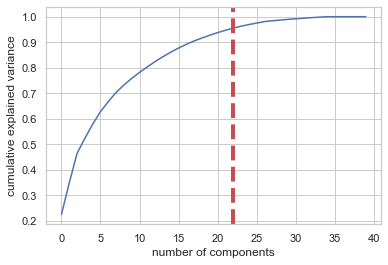

None

,Cumulative Variance Ratio,Explained Variance Ratio
0,0.226023,0.226023
1,0.349509,0.123485
2,0.464906,0.115397
3,0.523625,0.058719
4,0.579297,0.055672
5,0.628175,0.048878
6,0.667447,0.039272
7,0.703593,0.036146
8,0.732379,0.028786
9,0.758396,0.026017


In [26]:
from sklearn.decomposition import PCA
import seaborn as sns

from sklearn.model_selection import train_test_split
X= AimoscoreData.drop(["AimoScore"], axis=1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

pca_test=PCA(n_components=40)
pca_test.fit(train_X)

sns.set(style='whitegrid')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(linewidth=4, color='r', linestyle = '--', x=22, ymin=0, ymax=1)
display(plt.show())
evr = pca_test.explained_variance_ratio_
cvr = np.cumsum(pca_test.explained_variance_ratio_)
pca_df = pd.DataFrame()
pca_df['Cumulative Variance Ratio'] = cvr
pca_df['Explained Variance Ratio'] = evr
display(pca_df.head(26))

#### interpretation:

This graph shows that after more than 22 components, we don’t gain very much explained variance

Looking at the dataframe above, when we use PCA to reduce our 40 predicting variables down to 21 components, we can still explain over 95% of the variance

### 2.4 Dimentionaly reduction with Feature selection method

We use Feature selection method for dimentionaly reduction .


Hyperparameter Tuning Using Grid Search Cross-Validation for Optimal number features

Fitting 5 folds for each of 38 candidates, totalling 190 fits


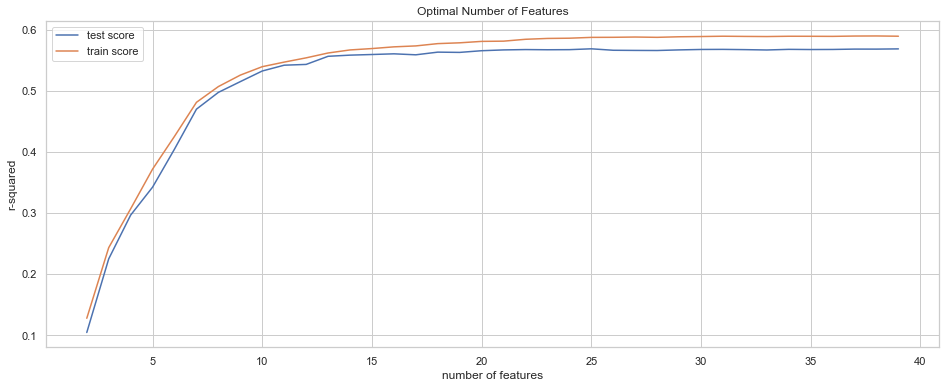

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

# specify range of hyperparameters
hyper_params = [{'n_features_to_select': list(range(2, 40))}]

# specify model
lm = LinearRegression()
lm.fit(X, y)
rfe = RFE(lm)             

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= 'r2', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True,refit=True)      

# fit the model
model_cv.fit(X,y ) 
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
plt.xlabel('number of features')
plt.ylabel('r-squared')
plt.title("Optimal Number of Features")
plt.legend(['test score', 'train score'], loc='upper left')


In [28]:
from sklearn.feature_selection import RFE
print(model_cv.best_estimator_)
print(model_cv.best_score_)



RFE(estimator=LinearRegression(), n_features_to_select=25)
0.569359928583445


#### interpretation:

Feature selection method show whith 25 features we have the best r2 


### 3. Perform “Baseline” model 


#### 3.1Perform simpele Linear regression

Now we fit to  “baseline” simpele Linear regression. This model uses all of the predicting features. First, we use cross validation the model and fit the data to it. We select the R_squerd metric to evaluate the regression.

In [29]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
lr = LinearRegression()

print('LinearRegression_neg_mean_squared_error:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('LinearRegression_neg_mean_absolute_error:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('LinearRegression_r2:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='r2')))
LinearRegression_r2=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='r2'))
LinearRegression_neg_mean_absolute_error=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_absolute_error'))
LinearRegression_neg_mean_squared_error=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error'))

LinearRegression_neg_mean_squared_error: -0.0239927984267916
LinearRegression_neg_mean_absolute_error: -0.11775574224018233
LinearRegression_r2: 0.569868036241301


#### hypethesis1:
    
H0:Deleting duplicates data, can improve our baseline model


HA:Deleting duplicates data, cant improve our baseline model


In [30]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

AimoscoreData_duplicated=AimoscoreData.drop_duplicates()
AimoscoreData_duplicated

X= AimoscoreData_duplicated.drop(["AimoScore"], axis =1)
y = AimoscoreData_duplicated["AimoScore"]
lr = LinearRegression()

print('Regression_dublicateremove_neg_mean_squared_error:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('Regression_dublicateremove_neg_mean_absolute_error:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('Regression_dublicateremove_r2:',np.mean(cross_val_score(lr, X, y, cv=cv, scoring='r2')))
Regression_dublicateremove_r2=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='r2'))
Regression_dublicateremove_neg_mean_absolute_error=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_absolute_error'))
Regression_dublicateremove_neg_mean_squared_error=np.mean(cross_val_score(lr, X, y, cv=cv, scoring='neg_mean_squared_error'))


Regression_dublicateremove_neg_mean_squared_error: -0.02418506684407023
Regression_dublicateremove_neg_mean_absolute_error: -0.11842173312146236
Regression_dublicateremove_r2: 0.5677401034355533


In [31]:
print("Percentage_change_r2:",get_percentage(Regression_dublicateremove_r2,LinearRegression_r2))
print("neg_mean_absolute_error_percentage:",get_percentage(Regression_dublicateremove_neg_mean_absolute_error,LinearRegression_neg_mean_absolute_error))
print("neg_mean_mean_error_percentage:",get_percentage(Regression_dublicateremove_neg_mean_squared_error,LinearRegression_neg_mean_squared_error))


Percentage_change_r2: -0.37340799455660434
neg_mean_absolute_error_percentage: 0.5655697706202961
neg_mean_mean_error_percentage: 0.8013588655166225


#### interpretation:
According to R-squerd values compare to baseline model hypethesis1 is not significant.so we keep the duplicated data.

#### hypethesis2:
    
H0:Using dimension reduction which uses of PCA method, can improve our baseline model.

HA:Using dimension reduction which uses of PCA method, can't improve our baseline model

We instantiate the PCA function and set the number of components (features) that we want to consider. According to part 2.3 Dimentionaly reduction with PCA method, We’ll set it to “21”  Then we “fit” our data whitout remove outlire to the PCA function.

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

pca= PCA(n_components=25)
pipe= Pipeline([('pca',pca),('Regression',LinearRegression())])
pipe.fit(X,y)
    
print('Regression_PCA_neg_mean_squared_error:',np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('Regression_PCA_neg_mean_absolute_error:',np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('Regression_PCA_r2:',np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='r2')))
Regression_PCA_r2=np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='r2'))
Regression_PCA_neg_mean_absolute_error=np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_absolute_error'))
Regression_PCA_neg_mean_squared_error=np.mean(cross_val_score(pipe, X, y, cv=cv, scoring='neg_mean_squared_error'))



Regression_PCA_neg_mean_squared_error: -0.024624757834703546
Regression_PCA_neg_mean_absolute_error: -0.11902835113283206
Regression_PCA_r2: 0.5585929945215555


In [33]:
print("r2_percentage:",get_percentage(Regression_PCA_r2,LinearRegression_r2))
print("neg_mean_absolute_error_percentage:",get_percentage(Regression_PCA_neg_mean_absolute_error,LinearRegression_neg_mean_absolute_error))
print("neg_mean_mean_error_percentage:",get_percentage(Regression_PCA_neg_mean_squared_error,LinearRegression_neg_mean_squared_error))

r2_percentage: -1.9785355560758517
neg_mean_absolute_error_percentage: 1.0807191806018275
neg_mean_mean_error_percentage: 2.6339545586573307


#### interpretation:

According to R-squerd values compare to baseline model hypethesis2 is significant.

#### hypethesis3:

H0:Using PCA method whith remove outlier can improve our PCA model.

HA:Using PCA method whith remove outlier can't improve our PCA model.

We instantiate the PCA function and set the number of components (features) that we want to consider. According to part 2.3 Dimentionaly reduction with PCA method, We’ll set it to “21” Then we “fit” our data whit remove outlire to the PCA function.


In [34]:
from sklearn.compose import ColumnTransformer
outlier_remover = OutlierRemover()
ct = ColumnTransformer(transformers=[['outlier_remover',OutlierRemover(),list(range(AimoscoreData.shape[1]))]],remainder='passthrough')
data_without_outliers = pd.DataFrame(ct.fit_transform(AimoscoreData),columns=AimoscoreData.columns)

In [37]:

X= AimoscoreData.drop(["AimoScore"], axis =1).copy()
y = AimoscoreData["AimoScore"].copy()

pca= PCA(n_components=25)

pipe1= Pipeline([('outlier_removal',outlier_remover),('imputer',SimpleImputer()),('pca',pca),('Regression',LinearRegression())])
pipe1.fit(X,y)

print('Regression_PCA_neg_mean_squared_error:',np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('Regression_PCA_neg_mean_absolute_error:',np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('Regression_PCA_r2:',np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='r2')))
Regression_PCA_removoutlier_r2=np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='r2'))
Regression_PCA_removoutlier_neg_mean_absolute_error=np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='neg_mean_absolute_error'))
Regression_PCA_removoutlier_neg_mean_squared_error=np.mean(cross_val_score(pipe1, X, y, cv=cv, scoring='neg_mean_squared_error'))

Regression_PCA_neg_mean_squared_error: -0.024671851442161767
Regression_PCA_neg_mean_absolute_error: -0.1190489112867618
Regression_PCA_r2: 0.5577579931584644


In [38]:
print("r2_percentage:",get_percentage(Regression_PCA_removoutlier_r2,LinearRegression_r2))
print("neg_mean_absolute_error_percentage:",get_percentage(Regression_PCA_removoutlier_neg_mean_absolute_error,LinearRegression_neg_mean_absolute_error))
print("neg_mean_mean_error_percentage:",get_percentage(Regression_PCA_removoutlier_neg_mean_squared_error,LinearRegression_neg_mean_squared_error))

r2_percentage: -2.1250609461641345
neg_mean_absolute_error_percentage: 1.0981791817352233
neg_mean_mean_error_percentage: 2.8302368206115407


#### interpretation:

According to R-squerd values compare to baseline model hypethesis3 is not significant.

#### hypethesis4:

H0:Using dimension reduction which uses of Feature selection method, can improve our baseline model.

HA:Using dimension reduction which uses of Feature selection method, can't improve our baseline model.


In [39]:
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

lr = LinearRegression()
rfe = RFE(lr,n_features_to_select=25)

print('Regression_featureselection_neg_mean_squared_error:',np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('Regression_featureselection_neg_mean_absolute_error:',np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('Regression_featureselection_r2:',np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='r2')))
Regression_featureselection_r2=np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='r2'))
Regression_featureselection_neg_mean_absolute_error=np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='neg_mean_absolute_error'))
Regression_featureselection_neg_mean_squared_error=np.mean(cross_val_score(rfe, X, y, cv=cv, scoring='neg_mean_squared_error'))


Regression_featureselection_neg_mean_squared_error: -0.024022049891012205
Regression_featureselection_neg_mean_absolute_error: -0.11767142187325748
Regression_featureselection_r2: 0.569359928583445


In [40]:
print("r2_percentage:",get_percentage(Regression_featureselection_r2,LinearRegression_r2))
print("neg_mean_absolute_error_percentage:",get_percentage(Regression_featureselection_neg_mean_absolute_error,LinearRegression_neg_mean_absolute_error))
print("neg_mean_error_percentage:",get_percentage(Regression_featureselection_neg_mean_squared_error,LinearRegression_neg_mean_squared_error))

r2_percentage: -0.08916233681175928
neg_mean_absolute_error_percentage: -0.07160616146672925
neg_mean_error_percentage: 0.12191768421619464


#### interpretation:

According to R_squerd values compare to baseline model hypethesis4 is not  significant.

We show the comparison of values R_squerd in different hypotheses In the bar plot

Text(0, 0.5, 'r2')

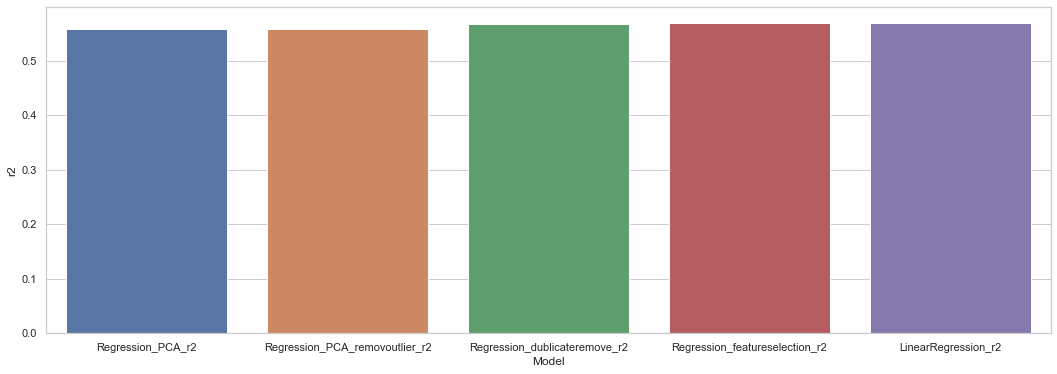

In [41]:
results = pd.DataFrame({"r2":[LinearRegression_r2,Regression_dublicateremove_r2,Regression_PCA_r2,Regression_PCA_removoutlier_r2,Regression_featureselection_r2],"Model":['LinearRegression_r2','Regression_dublicateremove_r2', 'Regression_PCA_r2', 'Regression_PCA_removoutlier_r2', 'Regression_featureselection_r2']})
fig, ax = plt.subplots(figsize=(18,6))

sns.barplot(data=results, x="Model", y="r2",ax=ax,order=results.sort_values("r2").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("r2")


In [42]:
start_time = time.time()

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

lr = LinearRegression()
rfe = RFE(lr,n_features_to_select=25).fit(train_X,train_y)
predict=rfe.predict(test_X)

end_time = time.time()
print("Execution time: ", end_time - start_time,"secs")
Execution_time_LinearRegression_feature_selection= end_time - start_time

Execution time:  0.06450295448303223 secs


In [43]:
start_time = time.time()

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

pca= PCA(n_components=25)
pipe= Pipeline([('pca',pca),('Regression',LinearRegression())])
pipe.fit(train_X,train_y)
predict=pipe.predict(test_X)

end_time = time.time()
print("Execution time: ", end_time - start_time,"secs")
Execution_time_LinearRegression_pca= end_time - start_time

Execution time:  0.03251004219055176 secs


In [44]:
start_time = time.time()
" YOUR CODE HERE "
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )
lr = LinearRegression().fit(train_X,train_y)
predict=lr.predict(test_X)

end_time = time.time()
print("Execution time: ", end_time - start_time,"secs")
Execution_time_LinearRegression= end_time - start_time

Execution time:  0.013810873031616211 secs


Text(0, 0.5, 'Execution time')

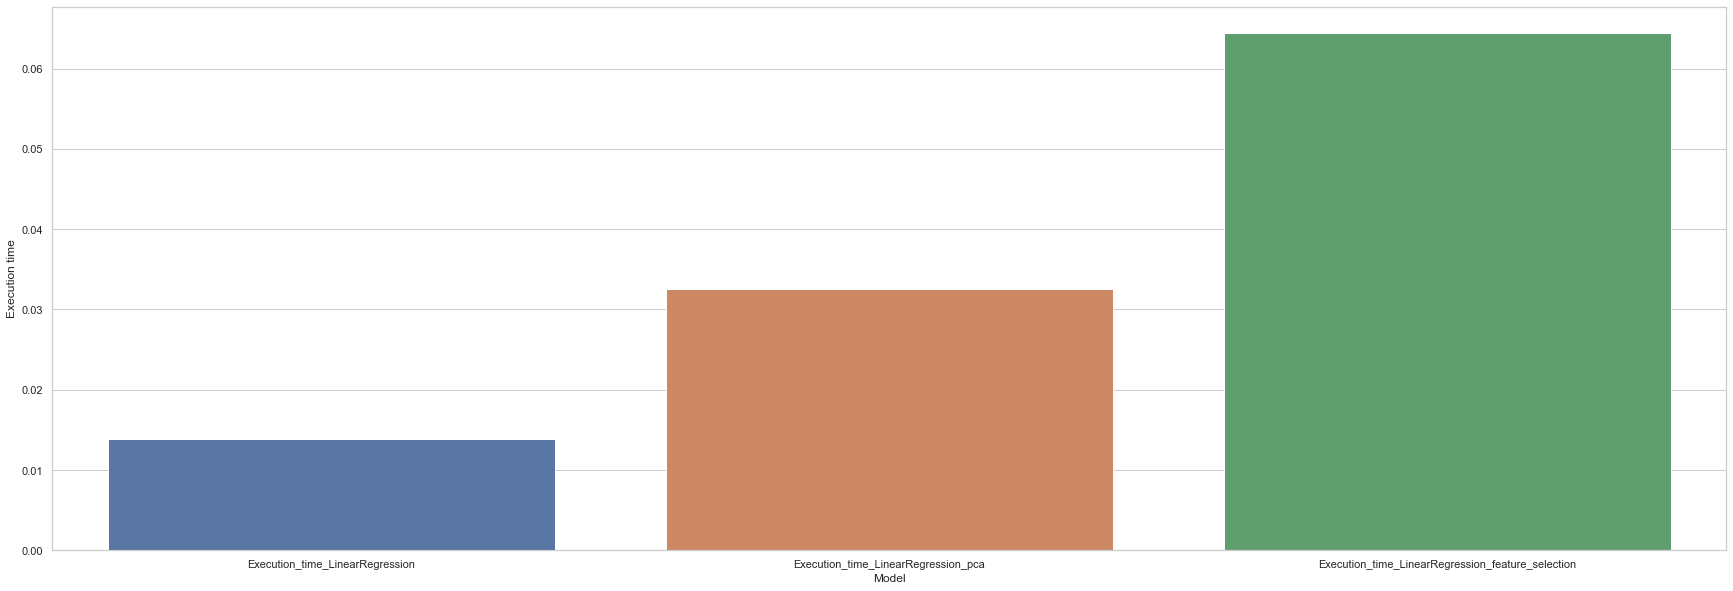

In [45]:
results2 = pd.DataFrame({"Execution time":[Execution_time_LinearRegression,
                                           Execution_time_LinearRegression_pca,
                                           Execution_time_LinearRegression_feature_selection,
                             ],
                        "Model":['Execution_time_LinearRegression',
                                 'Execution_time_LinearRegression_pca',
                                 'Execution_time_LinearRegression_feature_selection',
                                 ]})
fig, ax = plt.subplots(figsize=(30,10))


sns.barplot(data=results2, x="Model", y="Execution time",ax=ax,order=results2.sort_values("Execution time").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("Execution time")

#### interpretation:

As shown in the bar plot use of Featureselection and PCA whitout remove the outlier an regression is the same R_Squerd

The best R-squerd for lineer regression model is 0.56

### 4.we use cross validation for find the best polynomial degree


The function crossvalidation_polynomial_regression_model() performs cross-validation in order to determine the degree polynomial 

We use the argument scoring='r2' in order to indicate which polyomial degree have lowest mean_squerd_error

We also use the function crossvalidationplotpolynomial_regression() to illustrate the result on a plot to have a clear image of the results

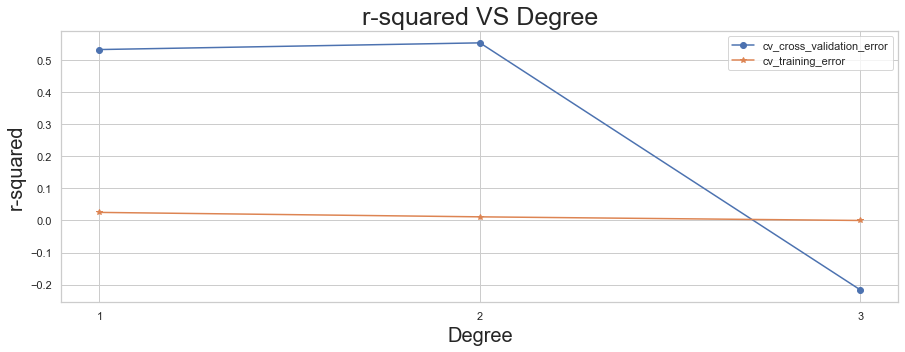

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score

X= AimoscoreData[columns_without_highcorrolation].drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

cv_cross_validation_error,cv_training_error =crossvalidation_polynomial_regression_model(X,y,cv=cv,scoring='r2',mindegree=1,maxdegree=maxdegree)

crossvalidationplotpolynomial_regression(cv_cross_validation_error,cv_training_error,mindegree=1,maxdegree=maxdegree)

Text(0, 0.5, 'r_squerd')

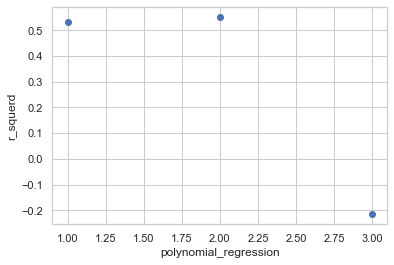

In [47]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

X= AimoscoreData[columns_without_highcorrolation].drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

def create_polynomial_regression_model(degree):
    
     poly_features = PolynomialFeatures(degree=degree)        
     X_poly = poly_features.fit_transform(X)
     poly = LinearRegression()
     return np.mean(cross_val_score(poly, X_poly, y, cv=5))

poly_cv = []
for i in range(1,4):
 poly_cv.append(create_polynomial_regression_model(i))
plt.scatter(range(1,4),poly_cv)
plt.xlabel('polynomial_regression')
plt.ylabel('r_squerd')


#### interpretation:

According to cross validation the best degree for polynomial is 2. We have more R_squerd in degree 2 almost 56%.

#### 4.1 Perform model with polynomial degree 2

In [49]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=2)
pipe_poly= Pipeline([('poly',poly_features),('Regression',LinearRegression())])
pipe_poly.fit(X,y)
print('r2:',np.mean(cross_val_score(pipe_poly, X, y, cv=cv, scoring='r2')))
print('neg_mean_absolute_error:',np.mean(cross_val_score( pipe_poly, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('neg_mean_squared_error:',np.mean(cross_val_score( pipe_poly, X, y, cv=cv, scoring='neg_mean_squared_error')))

r2: 0.491133437260574
neg_mean_absolute_error: -0.1236806043640624
neg_mean_squared_error: -0.028399507289395397


In [48]:
from sklearn.decomposition import KernelPCA
from sklearn.model_selection import cross_val_score

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

kpca = KernelPCA(n_components = 25, kernel = 'poly',degree=2)
pipe3=Pipeline([('kpca',kpca),('Regression',LinearRegression())])
pipe3.fit(X,y)

print('Regressionpoly_neg_mean_squared_error:',np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='neg_mean_squared_error')))
print('Regressionpoly_neg_mean_absolute_error:',np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='neg_mean_absolute_error')))
print('Regressionpoly_r2:',np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='r2')))
Regressionpoly_r2=np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='r2'))
Regressionpoly_neg_mean_absolute_error=np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='neg_mean_absolute_error'))
Regressionpoly_neg_mean_squared_error=np.mean(cross_val_score(pipe3, X , y, cv=cv, scoring='neg_mean_squared_error'))


Regressionpoly_neg_mean_squared_error: -0.024448453656404003
Regressionpoly_neg_mean_absolute_error: -0.11836306864850532
Regressionpoly_r2: 0.5617500276759998


In [50]:
print("r2_percentage:",get_percentage(Regressionpoly_r2,Regression_PCA_r2))
print("neg_mean_absolute_error_percentage:",get_percentage(Regressionpoly_neg_mean_absolute_error,Regression_PCA_neg_mean_absolute_error))
print("neg_mean_error_percentage:",get_percentage(Regressionpoly_neg_mean_squared_error,Regression_PCA_neg_mean_squared_error))

r2_percentage: 0.7157287867681361
neg_mean_absolute_error_percentage: -0.5761015626631328
neg_mean_error_percentage: -0.9054763736781667


#### interpretation:

According to r2 values compare to baseline model hypethesis_poly1 is   significant.

Text(0, 0.5, 'r2')

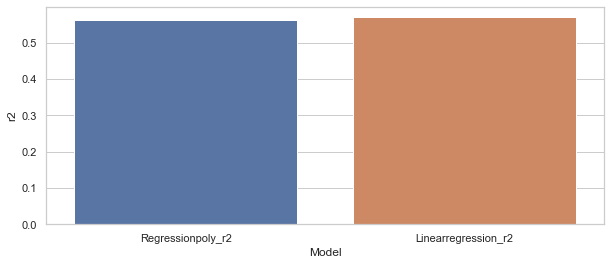

In [51]:
results = pd.DataFrame({"r2":[LinearRegression_r2,Regressionpoly_r2],"Model":['Linearregression_r2','Regressionpoly_r2']})
fig, ax = plt.subplots(figsize=(10,4))

sns.barplot(data=results, x="Model", y="r2",ax=ax,order=results.sort_values("r2").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("r2")


#### interpretation:

As shown in the bar plot use of dimension reduction whith two methods PCA(with remove outlier and without remove outlier) could improve baseline model.

The best R-squared for the polynomial model with PCA without removing outlier is 0.56 which compared to the linear regression model we don't have significant change.

### 5. We creat model with Decission Tree


#### 5.1 we use cross validation for find the best decision tree depth


The function crossValidationOnTreeRegressor() performs cross-validation in order to determine the best decision tree depth

We use the argument scoring='r2' in order to indicate which tree depth have lowest mean_squerd_error

We also use the function crossValidationPlotOnTree() to illustrate the result on a plot to have a clear image of the results

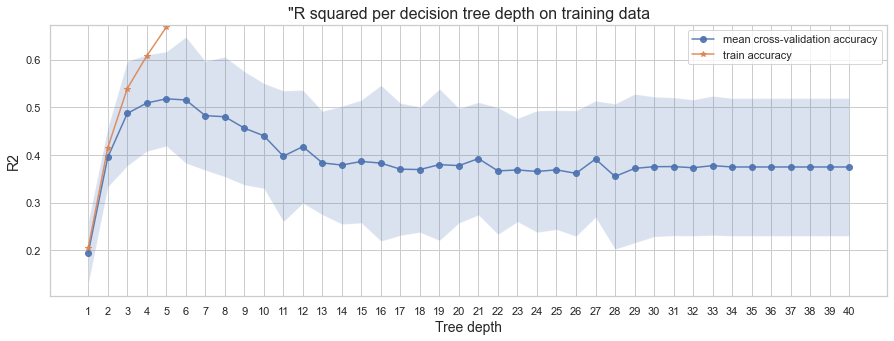

In [52]:
X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

cv_means, cv_stds, cv_accuracies = crossValidationOnTreeRegressor(X,y,minDepths=minDepths,maxDepths=maxDepths, cv=cv)
crossValidationPlotOnTree(minDepths,maxDepths, cv_means, cv_stds, cv_accuracies, 
                               '"R squared per decision tree depth on training data')

##### interpretation:

As it exhibited on the cross validation plot, depth of 5 will be the best choice. 

In keeping with the cross-validation results, use the best tree depth.

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
tree_1 = DecisionTreeRegressor(max_depth=5,random_state=random_state )
tree_1.fit(X,y)


print('DecisionTreeRegresso_neg_mean_squared_error:',np.mean(cross_val_score(tree_1, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('DecisionTreeRegresso_neg_mean_absolute_error:',np.mean(cross_val_score(tree_1, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('DecisionTreeRegresso_r2:',np.mean(cross_val_score(tree_1, X, y, cv=cv, scoring='r2')))
DecisionTreeRegresso_r2=np.mean(cross_val_score(tree_1, X, y, cv=cv, scoring='r2'))
DecisionTreeRegresso_neg_mean_absolute_error=np.mean(cross_val_score(tree_1, X ,y, cv=cv, scoring='neg_mean_absolute_error'))
DecisionTreeRegresso_neg_mean_squared_error=np.mean(cross_val_score(tree_1, X, y, cv=cv, scoring='neg_mean_squared_error'))



DecisionTreeRegresso_neg_mean_squared_error: -0.026201024626524416
DecisionTreeRegresso_neg_mean_absolute_error: -0.11744585733215832
DecisionTreeRegresso_r2: 0.530318290304981


### 6. Perform model with Random Forest


The library function GridserchCv determine the best parameter for Random forest.

In [54]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

parameters = { 'max_depth': range(5,12), 'n_estimators': (10, 50, 100,150,250) }

randomForest = RandomForestRegressor()

model_cv = GridSearchCV(estimator = randomForest, 
                        param_grid = parameters, 
                        scoring= 'r2', 
                        cv = cv, 
                    
                        return_train_score=True,refit=True)      

# fit the model
model_cv.fit(X,y ) 

print(model_cv.best_params_)
print(model_cv.best_score_)

{'max_depth': 11, 'n_estimators': 250}
0.7069032129309075


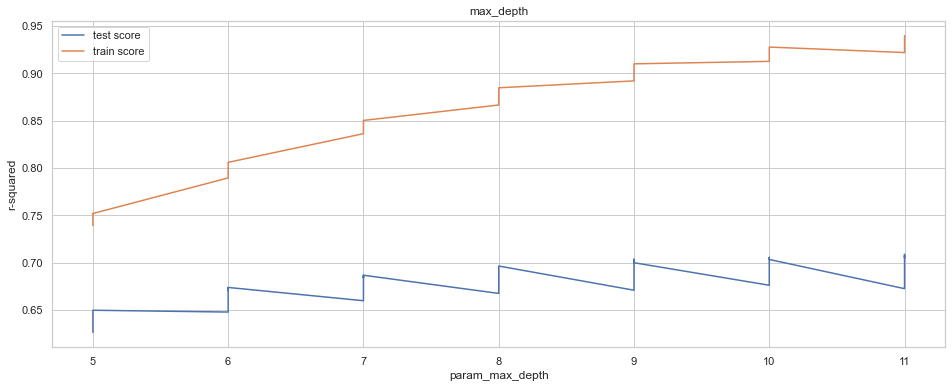

In [55]:
model_cv.fit(X,y ) 
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.figure(figsize=(16,6))

plt.plot(cv_results["param_max_depth"], cv_results["mean_test_score"])
plt.plot(cv_results["param_max_depth"], cv_results["mean_train_score"])
plt.xlabel('param_max_depth')
plt.ylabel('r-squared')
plt.title("max_depth")
plt.legend(['test score', 'train score'], loc='upper left')

As it exhibited on the plot, depth of 9 will be the best choice. 

In [56]:
from sklearn.ensemble import RandomForestRegressor

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
randomForest = RandomForestRegressor(max_depth=11,n_estimators=150)
randomForest.fit(X, y)


print('RandomForestRegresso_neg_mean_squared_error:',np.mean(cross_val_score(randomForest, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('RandomForestRegresso_neg_mean_absolute_error:',np.mean(cross_val_score(randomForest, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('RandomForestRegresso_r2:',np.mean(cross_val_score(randomForest, X, y, cv=cv, scoring='r2')))
RandomForestRegresso_r2=np.mean(cross_val_score(randomForest, X, y, cv=cv, scoring='r2'))
RandomForestRegresso_neg_mean_absolute_error=np.mean(cross_val_score(randomForest, X ,y, cv=cv, scoring='neg_mean_absolute_error'))
RandomForestRegresso_neg_mean_squared_error=np.mean(cross_val_score(randomForest, X, y, cv=cv, scoring='neg_mean_squared_error'))

RandomForestRegresso_neg_mean_squared_error: -0.016282154267878532
RandomForestRegresso_neg_mean_absolute_error: -0.09295997102076634
RandomForestRegresso_r2: 0.7069309624987026


### 7. Perform model with SVR



#### 7.1  The library function GridserchCv determine the best parameter for estimate kernel and degree



In [57]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

parameters = {'kernel':('linear', 'rbf','poly','sigmoid'), 'degree':[1,2,3],'C':[0.1,1,10]}
svr = SVR()


model_cv = GridSearchCV(estimator = svr, 
                        param_grid = parameters, 
                        scoring= 'r2', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True,refit=True)      

# fit the model
model_cv.fit(X,y ) 

model_cv.best_params_

Fitting 5 folds for each of 36 candidates, totalling 180 fits


{'C': 1, 'degree': 1, 'kernel': 'rbf'}

In [58]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

parameters = {'C':[0.4,0.7,1,1.3,1.5]}
svr = SVR(kernel='rbf',degree=1)


model_cv = GridSearchCV(estimator = svr,
                    
                        param_grid = parameters, 
                        scoring= 'r2', 
                        cv = cv, 
                        verbose = 1,
                        return_train_score=True,refit=True)      

# fit the model
model_cv.fit(X,y ) 

model_cv.best_params_

Fitting 5 folds for each of 5 candidates, totalling 25 fits


{'C': 0.4}

In [59]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score


X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

model2 = SVR(kernel='rbf',degree= 1,C=0.4) # set kernel and hyperparameters
svr = model2.fit(X, y)


print('SVR_neg_mean_squared_error:',np.mean(cross_val_score(svr, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('SVR_neg_mean_absolute_error:',np.mean(cross_val_score(svr, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('SVR_r2:',np.mean(cross_val_score(svr, X, y, cv=cv, scoring='r2')))
SVR_r2=np.mean(cross_val_score(svr, X, y, cv=cv, scoring='r2'))
SVR_neg_mean_absolute_error=np.mean(cross_val_score(svr, X ,y, cv=cv, scoring='neg_mean_absolute_error'))
SVR_neg_mean_squared_error=np.mean(cross_val_score(svr, X, y, cv=cv, scoring='neg_mean_squared_error'))



SVR_neg_mean_squared_error: -0.01729553401273911
SVR_neg_mean_absolute_error: -0.10182494470569506
SVR_r2: 0.68996964017683


### 8. Perform model with Knn

#### 8.1 we use cross validation for find the best K



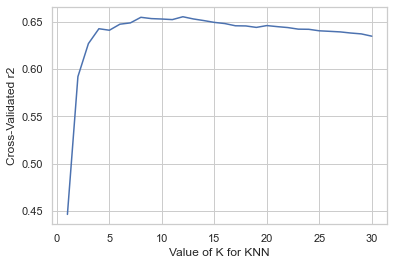

In [60]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor



X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

k_range = range(1, 31)
k_scores = []

for k in k_range:
    knn = KNeighborsRegressor(n_neighbors=k)
    scores = cross_val_score(knn, X, y, cv=cv, scoring='r2')
    k_scores.append(scores.mean())

plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated r2')
plt.show()


As we can see the best K is  8 and 12, after 12 the R-squerd got decreased due to under-fitting.

In [61]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

knn = KNeighborsRegressor(n_neighbors=8)
knn.fit(X, y)


print('KNeighborsRegressor_neg_mean_squared_error:',np.mean(cross_val_score(knn, X, y, cv=cv, scoring='neg_mean_squared_error')))
print('KNeighborsRegressor_neg_mean_absolute_error:',np.mean(cross_val_score(knn, X, y, cv=cv, scoring='neg_mean_absolute_error')))
print('KNeighborsRegressor_r2:',np.mean(cross_val_score(knn, X, y, cv=cv, scoring='r2')))
KNeighborsRegressor_r2=np.mean(cross_val_score(knn, X, y, cv=cv, scoring='r2'))
KNeighborsRegressor_neg_mean_absolute_error=np.mean(cross_val_score(knn, X ,y, cv=cv, scoring='neg_mean_absolute_error'))
KNeighborsRegressor_neg_mean_squared_error=np.mean(cross_val_score(knn, X, y, cv=cv, scoring='neg_mean_squared_error'))


KNeighborsRegressor_neg_mean_squared_error: -0.019263249219450433
KNeighborsRegressor_neg_mean_absolute_error: -0.09819269898660658
KNeighborsRegressor_r2: 0.654916511322471


### 9. Compare  different Models in terms of R2

Text(0, 0.5, 'R2')

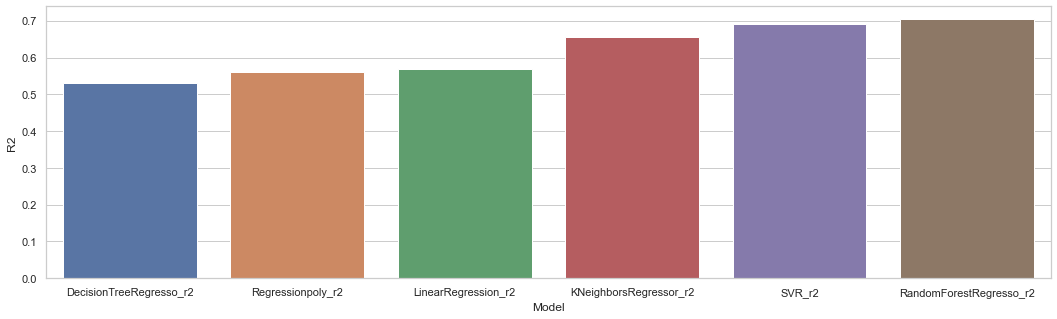

In [62]:
results = pd.DataFrame({"r2":[LinearRegression_r2,RandomForestRegresso_r2,DecisionTreeRegresso_r2,Regressionpoly_r2,KNeighborsRegressor_r2,SVR_r2],
                        "Model":['LinearRegression_r2','RandomForestRegresso_r2','DecisionTreeRegresso_r2','Regressionpoly_r2','KNeighborsRegressor_r2','SVR_r2']})
fig, ax = plt.subplots(figsize=(18,5))

sns.barplot(data=results, x="Model", y="r2",ax=ax,order=results.sort_values("r2").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("R2")

Text(0, 0.5, 'neg_mean_squared_error')

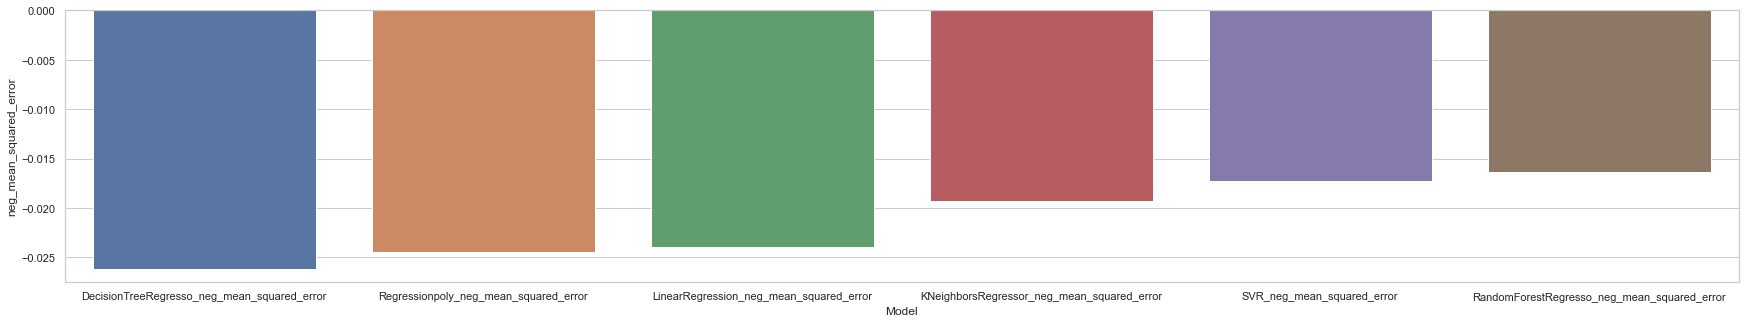

In [63]:
results1 = pd.DataFrame({"neg_mean_squared_error":[LinearRegression_neg_mean_squared_error,
                              RandomForestRegresso_neg_mean_squared_error,
                              DecisionTreeRegresso_neg_mean_squared_error,
                              Regressionpoly_neg_mean_squared_error,
                              KNeighborsRegressor_neg_mean_squared_error,
                              SVR_neg_mean_squared_error],
                        "Model":['LinearRegression_neg_mean_squared_error',
                                 'RandomForestRegresso_neg_mean_squared_error',
                                 'DecisionTreeRegresso_neg_mean_squared_error',
                                 'Regressionpoly_neg_mean_squared_error',
                                 'KNeighborsRegressor_neg_mean_squared_error',
                                 'SVR_neg_mean_squared_error']})
fig, ax = plt.subplots(figsize=(30,5))


sns.barplot(data=results1, x="Model", y="neg_mean_squared_error",ax=ax,order=results1.sort_values("neg_mean_squared_error").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("neg_mean_squared_error")

Text(0, 0.5, 'neg_mean_absolute_error')

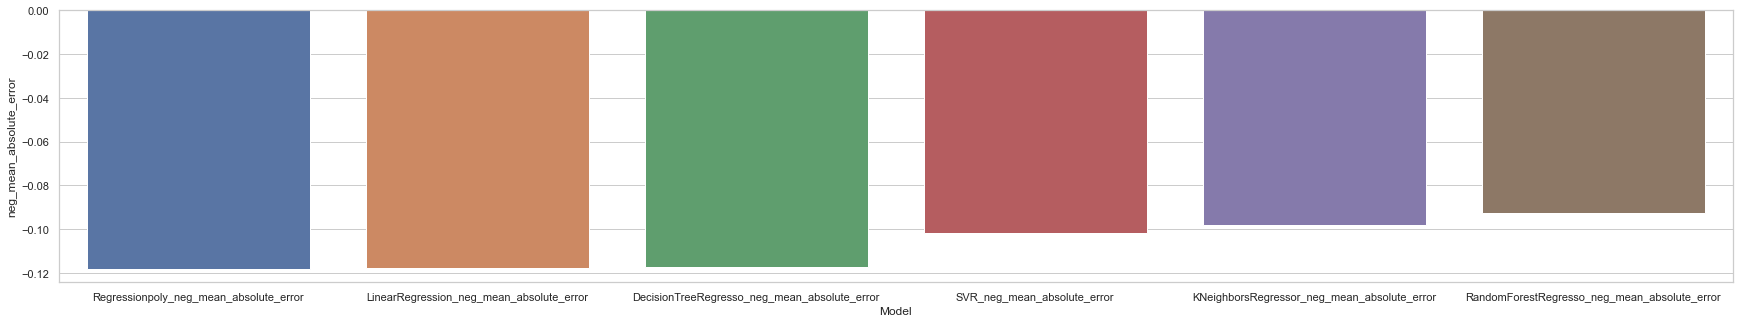

In [64]:
results2 = pd.DataFrame({"neg_mean_absolute_error":[LinearRegression_neg_mean_absolute_error,
                              RandomForestRegresso_neg_mean_absolute_error,
                              DecisionTreeRegresso_neg_mean_absolute_error,
                              Regressionpoly_neg_mean_absolute_error,
                              KNeighborsRegressor_neg_mean_absolute_error,
                              SVR_neg_mean_absolute_error],
                        "Model":['LinearRegression_neg_mean_absolute_error',
                                 'RandomForestRegresso_neg_mean_absolute_error',
                                 'DecisionTreeRegresso_neg_mean_absolute_error',
                                 'Regressionpoly_neg_mean_absolute_error',
                                 'KNeighborsRegressor_neg_mean_absolute_error',
                                 'SVR_neg_mean_absolute_error']})
fig, ax = plt.subplots(figsize=(30,5))


sns.barplot(data=results2, x="Model", y="neg_mean_absolute_error",ax=ax,order=results2.sort_values("neg_mean_absolute_error").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("neg_mean_absolute_error")

### 10. Use RandomForestRegressor model for predict test_y

0.01602241893131802
0.7316499035862223


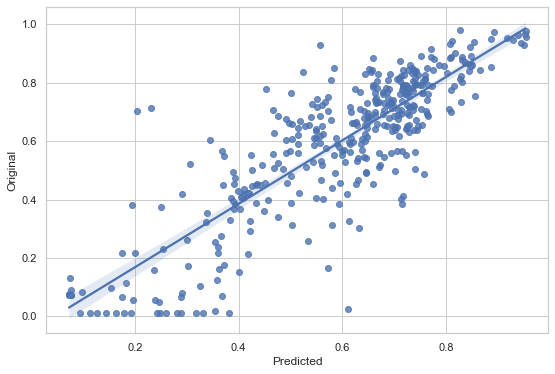

In [65]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

randomForest = RandomForestRegressor( random_state =random_state,max_depth=11,n_estimators=150)
Model=randomForest.fit(train_X,train_y)
predict=Model.predict(test_X)

print(mean_squared_error(test_y,predict))
print(r2_score(test_y, predict))

res = pd.DataFrame({"Original":test_y,"Predicted":predict})

fig, ax = plt.subplots(figsize=(9,6))
sns.regplot(y="Original", x="Predicted", data=res,ax=ax)
plt.xlabel("Predicted")
plt.ylabel("Original")
plt.show()



In [66]:

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )
randomForest = RandomForestRegressor(random_state =random_state,max_depth=11,n_estimators=150).fit(train_X,train_y)

start_time = time.time()
for i in range(1,100):
    predict=randomForest.predict(test_X)
end_time = time.time()

print("Execution time_RandomForestRegressor: ", (end_time - start_time)/100,"secs")
Execution_time_RandomForestRegressor= (end_time - start_time)/100

Execution time_RandomForestRegressor:  0.02155183792114258 secs


In [67]:

from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )
svr = SVR(kernel='rbf',degree= 1,C=0.4).fit(train_X,train_y)

start_time = time.time()
for i in range(1,100):
    predict=svr.predict(test_X)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_SVR= (end_time - start_time)/100

Execution time:  0.06169232130050659 secs


In [68]:

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

knn = KNeighborsRegressor(n_neighbors=8).fit(train_X,train_y)

start_time = time.time()
for i in range(1,100):
    predict=knn.predict(test_X)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_KNeighborsRegressor= (end_time - start_time)/100

Execution time:  0.016555218696594237 secs


In [69]:

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

tree_1 = DecisionTreeRegressor(max_depth=5,random_state=random_state ).fit(X,y)

start_time = time.time()
for i in range(1,100):
    predict=tree_1.predict(test_X)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_DecisionTreeRegressor= (end_time - start_time)/100

Execution time:  0.0014320731163024903 secs


In [71]:

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

pca=PCA(n_components=25).fit(train_X,test_X)
X_pca_train = pca.transform(train_X)
X_pca_test = pca.transform(test_X)
poly_X_train = PolynomialFeatures(degree=2).fit_transform(X_pca_train)
poly_X_test= PolynomialFeatures(degree=2).fit_transform(X_pca_test)

lr = LinearRegression().fit(poly_X_train,train_y)

start_time = time.time()
for i in range(1,100):
    predict=lr.predict(poly_X_test)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_PolynomialPCA= (end_time - start_time)/100

Execution time:  0.00020037889480590821 secs


In [72]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]

train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )
lr = LinearRegression().fit(train_X,train_y)

start_time = time.time()
for i in range(1,100):
    predict=lr.predict(test_X)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_LinearRegression= (end_time - start_time)/100

Execution time:  0.0018110799789428712 secs


In [73]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

X= AimoscoreData.drop(["AimoScore"], axis =1)
y = AimoscoreData["AimoScore"]
train_X, test_X, train_y, test_y= train_test_split(X, y, train_size= train_size ,random_state=random_state )

pca=PCA(n_components=25).fit(train_X,test_X)
X_pca_train = pca.transform(train_X)
X_pca_test = pca.transform(test_X)

lr = LinearRegression().fit(X_pca_train,train_y)

start_time = time.time()
for i in range(1,100):
    predict=lr.predict(X_pca_test)
end_time = time.time()

print("Execution time: ", (end_time - start_time)/100,"secs")
Execution_time_LinearRegression_pca= (end_time - start_time)/100


Execution time:  0.00012151718139648438 secs


Text(0, 0.5, 'Execution time')

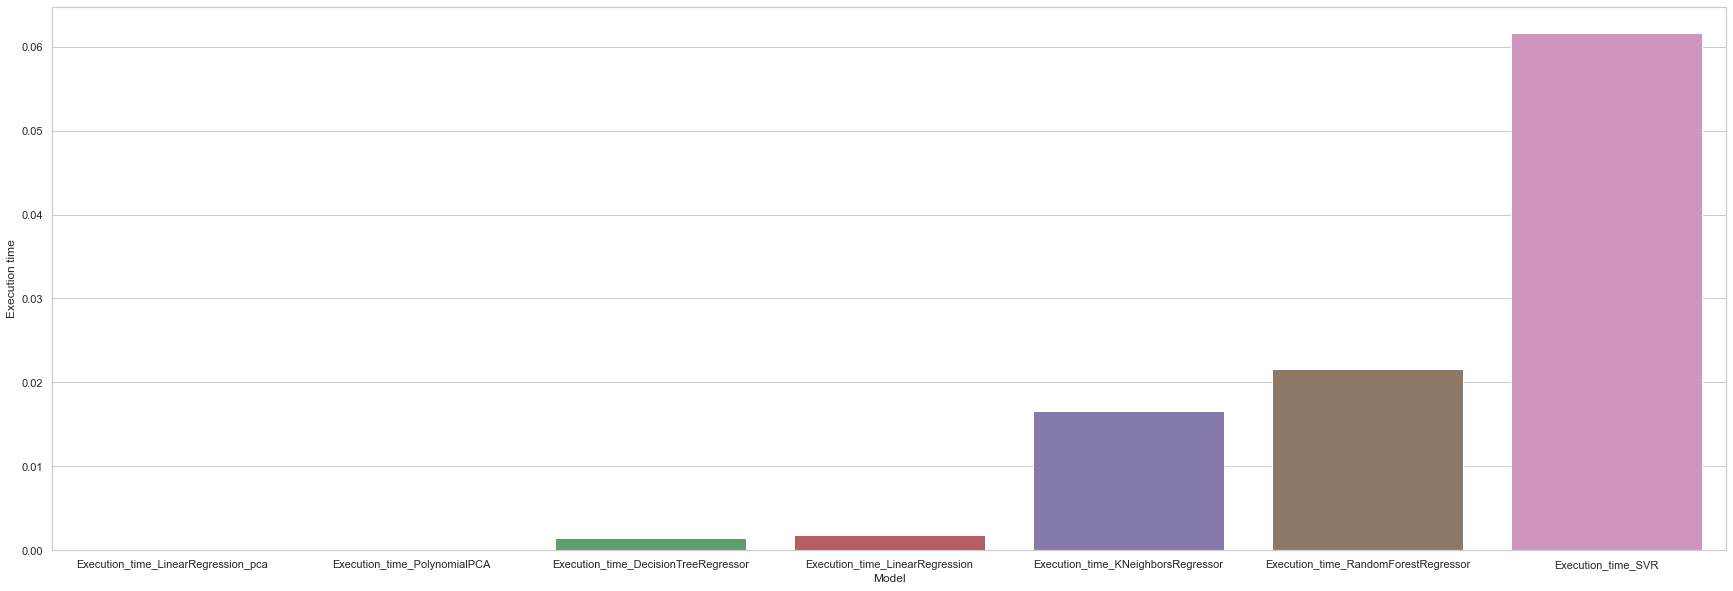

In [74]:
results2 = pd.DataFrame({"Execution time":[Execution_time_LinearRegression,Execution_time_LinearRegression_pca,
                              Execution_time_PolynomialPCA,
                              Execution_time_DecisionTreeRegressor,
                              Execution_time_KNeighborsRegressor,
                              Execution_time_SVR,
                              Execution_time_RandomForestRegressor],
                        "Model":['Execution_time_LinearRegression','Execution_time_LinearRegression_pca',
                                 'Execution_time_PolynomialPCA',
                                 'Execution_time_DecisionTreeRegressor',
                                 'Execution_time_KNeighborsRegressor',
                                 'Execution_time_SVR',
                                 'Execution_time_RandomForestRegressor']})
fig, ax = plt.subplots(figsize=(30,10))


sns.barplot(data=results2, x="Model", y="Execution time",ax=ax,order=results2.sort_values("Execution time").Model)

# Add labels to plot
plt.xlabel("Model")
plt.ylabel("Execution time")